# Introduction:
This notebook explores sales data from an online store over the past year to uncover actionable insights that can optimize its sales strategy. The dataset includes essential details such as order information (OrderID, OrderDate), customer data (CustomerID), product details (ProductID, ProductName), and sales metrics (Quantity, UnitPrice). By analyzing this dataset, we aim to identify trends, patterns, and opportunities that can help improve revenue generation, customer retention, and overall business performance.

In [81]:

import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
pysqldf = lambda q: sqldf(q,(globals))


## Reading the dataset and preforming EDA

In [82]:
dataSet = pd.read_excel("/kaggle/input/dataset/Dataset Structure.xlsx")

In [83]:
dataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5999 entries, 0 to 5998
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   OrderID      5999 non-null   int64 
 1   OrderDate    5999 non-null   object
 2   CustomerID   5999 non-null   object
 3   ProductID    5999 non-null   object
 4   ProductName  5999 non-null   object
 5   Quantity     5999 non-null   int64 
 6   UnitPrice.   5999 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 328.2+ KB


As we can see that the type of **OrderDate** column is object. lets change it.

In [84]:
dataSet["OrderDate"] = pd.to_datetime(dataSet["OrderDate"])

In [85]:
dataSet.describe()

,OrderID,OrderDate,Quantity,UnitPrice.
count,5999.000000,5999,5999.000000,5999.000000
mean,4001.000000,2023-07-02 21:32:36.926154752,10.488415,59.956659
min,1002.000000,2023-01-01 00:00:00,1.000000,40.000000
25%,2501.500000,2023-04-03 00:00:00,5.000000,48.000000
50%,4001.000000,2023-07-01 00:00:00,10.000000,60.000000
75%,5500.500000,2023-10-03 00:00:00,16.000000,72.000000
max,7000.000000,2023-12-31 00:00:00,20.000000,80.000000
std,1731.906464,NaN,5.833652,12.711411


Using pandasql for the analysis of dataSet

In [86]:
sqldf('''
         SELECT *
         FROM dataSet
         Limit 5

''')

,OrderID,OrderDate,CustomerID,ProductID,ProductName,Quantity,UnitPrice.
0,1002,2023-06-23 00:00:00.000000,C178,P018,Product 018,8,72
1,1003,2023-10-29 00:00:00.000000,C101,P019,Product 019,13,76
2,1004,2023-02-16 00:00:00.000000,C266,P011,Product 011,19,44
3,1005,2023-05-04 00:00:00.000000,C308,P016,Product 016,17,64
4,1006,2023-01-06 00:00:00.000000,C267,P015,Product 015,14,60


Need to change the name of colum from UnitPrice. to PricePerUnit as **"."** in the name was cauing errors

In [87]:
dataSet.rename(columns={"UnitPrice.":"PricePerUnit"},inplace = True)

Adding a **Revenue** column in our dataset

In [88]:
dataSet["Revenue"] = sqldf('''
                           SELECT Quantity * PricePerUnit
                           FROM dataSet
''')

In [89]:
sqldf('''
        SELECT *
        FROM dataSet
        LIMIT 5

''')

,OrderID,OrderDate,CustomerID,ProductID,ProductName,Quantity,PricePerUnit,Revenue
0,1002,2023-06-23 00:00:00.000000,C178,P018,Product 018,8,72,576
1,1003,2023-10-29 00:00:00.000000,C101,P019,Product 019,13,76,988
2,1004,2023-02-16 00:00:00.000000,C266,P011,Product 011,19,44,836
3,1005,2023-05-04 00:00:00.000000,C308,P016,Product 016,17,64,1088
4,1006,2023-01-06 00:00:00.000000,C267,P015,Product 015,14,60,840


# Analysis Questions

## 1. Month over month growth rate

In [90]:
sqldf('''
        WITH MonthlyRevenue AS (
    SELECT
        strftime('%Y-%m', OrderDate) AS Month,
        SUM(Revenue) AS TotalRevenue
    FROM dataSet
    GROUP BY Month
    ORDER BY Month
)
SELECT
    Month,
    TotalRevenue,
    LAG(TotalRevenue) OVER (ORDER BY Month) AS PreviousMonthRevenue,
    (TotalRevenue - LAG(TotalRevenue) OVER (ORDER BY Month)) * 100.0 / LAG(TotalRevenue) OVER (ORDER BY Month) AS GrowthRate
FROM MonthlyRevenue

''')

,Month,TotalRevenue,PreviousMonthRevenue,GrowthRate
0,2023-01,310356,NaN,NaN
1,2023-02,284580,310356.0,-8.305301
2,2023-03,308672,284580.0,8.465809
3,2023-04,313788,308672.0,1.657423
4,2023-05,330872,313788.0,5.444440
5,2023-06,319376,330872.0,-3.474455
6,2023-07,280592,319376.0,-12.143680
7,2023-08,318608,280592.0,13.548497
8,2023-09,318912,318608.0,0.095415
9,2023-10,316472,318912.0,-0.765101


In [91]:
Revenue_growth = sqldf('''
                          SELECT strftime('%Y %m',OrderDate) AS Month,
                                 SUM(Revenue) AS Total_Revenue
                          FROM dataSet
                          GROUP BY Month
                          ORDER BY Month
                        
''')

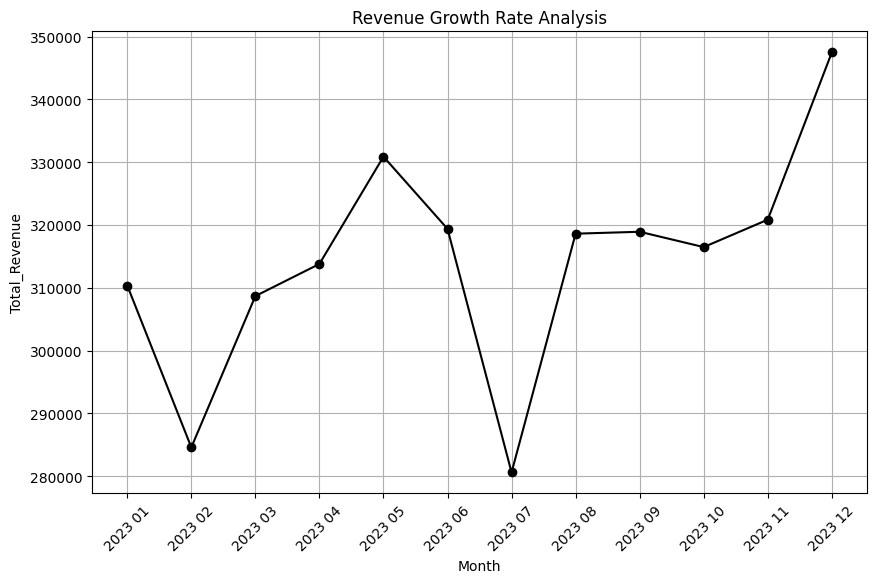

In [92]:
plt.figure(figsize = (10,6))
plt.plot(Revenue_growth.Month,Revenue_growth.Total_Revenue,color = "Black", marker = "o")
plt.xlabel("Month")
plt.xticks(rotation = 45)
plt.ylabel("Total_Revenue")
plt.title("Revenue Growth Rate Analysis")
plt.grid()
plt.show()

## Significant Changes

**February 2023 (-8.31%):**
Analysis: A significant decrease in revenue compared to January. This decline could be attributed to post-holiday sales slumps, where consumer spending typically drops after the holiday season.

**March 2023 (8.47%):**
Analysis: A rebound in revenue following the February decline. Possible factors could include new marketing campaigns, promotions, or the introduction of new products that attracted customers.

**July 2023 (-12.14%):**
Analysis: The most significant drop in revenue throughout the year. July is often a summer vacation month, where customers might be spending less on online shopping and more on travel and outdoor activities.

**August 2023 (13.55%):**
Analysis: A substantial increase following the July slump. Back-to-school sales and end-of-summer promotions likely contributed to this surge in revenue.

**December 2023 (8.30%):**
Analysis: A significant increase in revenue, likely driven by holiday shopping. December is traditionally a high-sales month due to the holiday season, with consumers purchasing gifts and taking advantage of holiday deals.

## General Trends

**Early Year Decline and Rebound:** The first quarter shows a decline followed by a rebound, possibly indicating the effects of post-holiday spending and subsequent recovery.

**Mid-Year Fluctuations:** The middle of the year exhibits volatility, with notable decreases in June and July, and a recovery in August. These fluctuations could be seasonal or related to specific events or promotions.

**End of Year Growth:** The last quarter shows a steady increase in revenue, culminating in a significant boost in December due to holiday shopping.


## Factors Contributing to Revenue Changes

### Seasonality:

**January and February:** Post-holiday season typically sees a decline in consumer spending.

**July:** Summer vacations may lead to reduced online shopping.

**December:** Holiday season drives higher sales.

### Marketing and Promotions:
Promotions and discounts during March, August, and the holiday season could boost sales.


## 2. Customer Lifetime Value (CLV) Calculation:

In [93]:
sqldf('''
        WITH CustomerStats AS (
    SELECT
        CustomerID,
        COUNT(DISTINCT OrderID) AS OrderCount,
        SUM(Revenue) AS TotalRevenue,
        AVG(Revenue) AS AvgOrderValue
    FROM dataSet
    GROUP BY CustomerID
),
CustomerCLV AS (
    SELECT
        CustomerID,
        TotalRevenue,
        OrderCount,
        AvgOrderValue,
        (OrderCount * AvgOrderValue) AS CLV
    FROM CustomerStats
)
SELECT
    CustomerID,
    TotalRevenue,
    OrderCount,
    AvgOrderValue,
    CLV
FROM CustomerCLV
ORDER BY CLV DESC
LIMIT 10;

''')

,CustomerID,TotalRevenue,OrderCount,AvgOrderValue,CLV
0,C045,15472,19,814.315789,15472.0
1,C027,15352,17,903.058824,15352.0
2,C281,15020,24,625.833333,15020.0
3,C384,14624,19,769.684211,14624.0
4,C289,14576,21,694.095238,14576.0
5,C275,14240,19,749.473684,14240.0
6,C188,14216,18,789.777778,14216.0
7,C198,13824,23,601.043478,13824.0
8,C372,13720,18,762.222222,13720.0
9,C333,13600,18,755.555556,13600.0


In [94]:
Customer_Lifetime_Value_Analysis = sqldf('''
        WITH CustomerStats AS (
    SELECT
        CustomerID,
        COUNT(DISTINCT OrderID) AS OrderCount,
        SUM(Revenue) AS TotalRevenue,
        AVG(Revenue) AS AvgOrderValue
    FROM dataSet
    GROUP BY CustomerID
),
CustomerCLV AS (
    SELECT
        CustomerID,
        TotalRevenue,
        OrderCount,
        AvgOrderValue,
        (OrderCount * AvgOrderValue) AS CLV
    FROM CustomerStats
)
SELECT
    CustomerID,
    TotalRevenue,
    OrderCount,
    AvgOrderValue,
    CLV
FROM CustomerCLV
ORDER BY CLV DESC
LIMIT 10;

''')

## Explanation:

### CustomerStats CTE:
CustomerID: Group by CustomerID to calculate statistics for each customer.

COUNT(OrderID) AS OrderCount: Count the number of orders for each customer.

SUM(Revenue) AS TotalRevenue: Sum the total revenue generated by each customer.

AVG(Revenue) AS AvgOrderValue: Calculate the average revenue per order for each customer.

### CustomerCLV CTE:
CustomerID: Retain the customer identifier.

TotalRevenue: Total revenue for each customer.

OrderCount: Number of orders placed by each customer.

AvgOrderValue: Average value of each order for each customer.

(OrderCount * AvgOrderValue) AS CLV: Calculate the Customer Lifetime Value by multiplying the number of orders by the average order value.

### Final Selection:
Select CustomerID, TotalRevenue, OrderCount, AvgOrderValue, and CLV.

Order the results by CLV in descending order to identify the top 10 customers.

Limit the results to the top 10 customers.

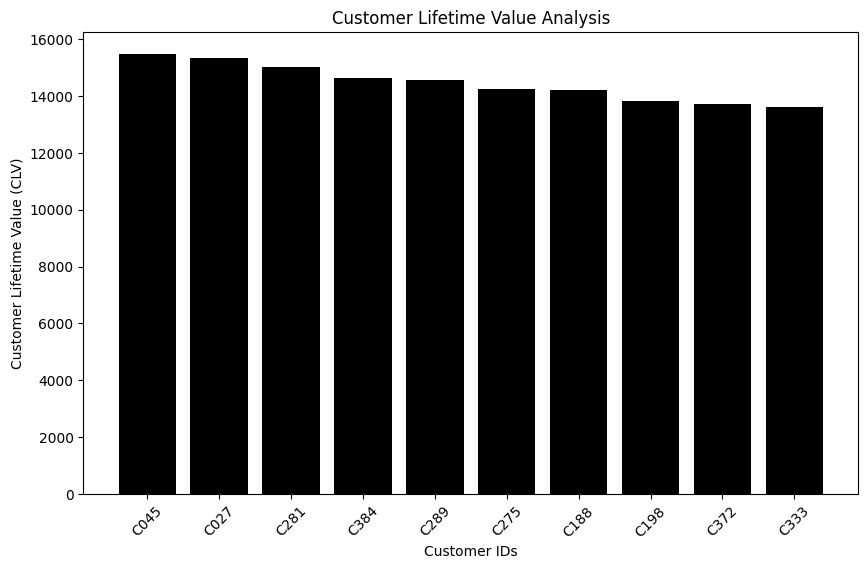

In [95]:
plt.figure(figsize = (10,6))
plt.bar(Customer_Lifetime_Value_Analysis.CustomerID,Customer_Lifetime_Value_Analysis.CLV, color = "Black")
plt.xlabel("Customer IDs")
plt.xticks(rotation = 45)
plt.ylabel("Customer Lifetime Value (CLV)")
plt.title("Customer Lifetime Value Analysis")
plt.show()

## Insights from CLV Analysis

### High CLV Customers:
Customers **C045, C027, and C281** are the highest CLV customers, with each generating over $15,000 in total revenue.
These customers have relatively high purchase frequencies and average order values, indicating consistent purchasing behavior and significant spending

### Purchase Frequency vs. Order Value:

Customer **C027** has a higher average order value ($903.06) compared to others but has made fewer orders (17) than C281 (24 orders with $625.83 average order value). This shows that different customers can have different spending patterns.
Focusing on both the frequency of purchases and the value per purchase can provide a balanced approach to understanding customer value.

### Retention Strategies:

High-value customers like **C045 and C027** should be prioritized for retention strategies. Providing personalized offers, loyalty rewards, and exceptional customer service can help retain these valuable customers.
Regular engagement with these customers through targeted marketing campaigns can also help maintain their loyalty.

### Customer Segmentation:

Segmenting customers based on their CLV can help tailor marketing strategies to different customer groups. For example, high CLV customers might receive exclusive deals, while efforts to increase the spending of lower CLV customers could focus on upselling and cross-selling.

### Revenue Optimization:

By understanding the purchasing patterns of these top customers, the store can optimize inventory to ensure that popular products are always in stock, minimizing the risk of lost sales.
The store can also identify which products are most frequently purchased by high CLV customers and prioritize those in marketing efforts.

### Growth Opportunities:

Identifying customers with high potential for growth based on their current CLV can help the store focus efforts on nurturing these relationships.
For example, customers with a moderate CLV but high purchase frequency might be encouraged to increase their average order value through targeted promotions.

## 3.Customer Churn Analysis:


In [96]:
# 1. Identify Churned Customers
sqldf('''WITH LastPurchase AS (
    SELECT
        CustomerID,
        MAX(OrderDate) AS LastOrderDate
    FROM dataSet
    GROUP BY CustomerID
)
SELECT
    CustomerID,
    LastOrderDate
FROM LastPurchase
WHERE LastOrderDate <= date('2023-12-31', '-6 months');
''')



,CustomerID,LastOrderDate
0,C111,2023-06-08 00:00:00.000000


In [97]:
# 2. Calculate Churn Rate
sqldf('''WITH LastPurchase AS (
    SELECT
        CustomerID,
        MAX(OrderDate) AS LastOrderDate
    FROM dataSet
    GROUP BY CustomerID
),
TotalCustomers AS (
    SELECT
        COUNT(DISTINCT CustomerID) AS TotalCustomerCount
    FROM dataSet
),
ChurnedCustomersCount AS (
    SELECT
        COUNT(DISTINCT CustomerID) AS ChurnedCustomerCount
    FROM LastPurchase
    WHERE LastOrderDate <= date('2023-12-31', '-6 months')
)
SELECT
    TotalCustomers.TotalCustomerCount,
    ChurnedCustomersCount.ChurnedCustomerCount,
    (CAST(ChurnedCustomersCount.ChurnedCustomerCount AS FLOAT) / TotalCustomers.TotalCustomerCount) * 100 AS ChurnRate
FROM TotalCustomers, ChurnedCustomersCount;


''')

,TotalCustomerCount,ChurnedCustomerCount,ChurnRate
0,500,1,0.2


In [98]:
# 3. Analyze Patterns Among Churned Customers

sqldf('''WITH LastPurchase AS (
    SELECT
        CustomerID,
        MAX(OrderDate) AS LastOrderDate
    FROM dataSet
    GROUP BY CustomerID
),
ChurnedCustomers AS (
    SELECT
        CustomerID
    FROM LastPurchase
    WHERE LastOrderDate <= date('2023-12-31', '-6 months')
),
ChurnedCustomerStats AS (
    SELECT
        ds.CustomerID,
        COUNT(ds.OrderID) AS OrderCount,
        SUM(ds.Revenue) AS TotalRevenue,
        AVG(ds.Revenue) AS AvgOrderValue
    FROM dataSet ds
    JOIN ChurnedCustomers cc ON ds.CustomerID = cc.CustomerID
    GROUP BY ds.CustomerID
)
SELECT
    AVG(OrderCount) AS AvgOrderCount,
    AVG(TotalRevenue) AS AvgTotalRevenue,
    AVG(AvgOrderValue) AS AvgOrderValue
FROM ChurnedCustomerStats;

''')

,AvgOrderCount,AvgTotalRevenue,AvgOrderValue
0,4.0,3184.0,796.0


## Explanation of the Queries

### Identify Churned Customers:

The LastPurchase Common Table Expression (CTE) calculates the last purchase date for each customer.
The main query then selects customers whose last purchase was more than 6 months ago.

### Calculate Churn Rate:

The TotalCustomers CTE calculates the total number of unique customers.
The ChurnedCustomersCount CTE calculates the number of churned customers using the LastPurchase CTE.
The final query calculates the churn rate by dividing the number of churned customers by the total number of customers and multiplying by 100 to get a percentage.

### Analyze Patterns Among Churned Customers:

The LastPurchase CTE calculates the last purchase date for each customer.
The ChurnedCustomers CTE identifies customers who have churned.
The ChurnedCustomerStats CTE calculates the total order count, total revenue, and average order value for each churned customer.
The final query calculates the average values of order count, total revenue, and average order value for churned customers to analyze their purchasing patterns.

## Recommendations to Reduce Customer Churn

### Analysis of Patterns
Given the data, we have only one churned customer, which makes it difficult to identify broad patterns. However, analyzing the purchasing behavior of this customer can still provide insights:

**Order Frequency:** The churned customer made an average of 4 orders.

**Revenue Contribution:** The customer contributed an average total revenue of 3184.0, with an average order value of 796.0.

### Strategies to Re-engage Churned Customers

**Personalized Offers:** Provide targeted discounts or special offers based on the customer’s purchase history to encourage them to return.

**Loyalty Programs:** Introduce or enhance loyalty programs that reward frequent purchases to motivate customers to stay engaged.

**Feedback Collection:**
Reach out to churned customers to understand why they stopped purchasing and address any issues or concerns they may have had.

**Regular Communication:**
Keep customers informed about new products, upcoming sales, or special events through newsletters or personalized emails.

**Customer Service:** Ensure that customer service is easily accessible and responsive to handle any queries or issues promptly.

## 4. Customer Segmentation and Behavior Analysis:

In [99]:
# Segment Customers Based on Total Spending

Customer_Segmentation = sqldf('''
         WITH CustomerSpending AS (
    SELECT
        CustomerID,
        SUM(Revenue) AS TotalSpending
    FROM dataSet
    GROUP BY CustomerID
),
CustomerSegments AS (
    SELECT
        CustomerID,
        TotalSpending,
        CASE
            WHEN TotalSpending >= 10000 THEN 'High Spender'
            WHEN TotalSpending >= 5000 AND TotalSpending < 10000 THEN 'Medium Spender'
            ELSE 'Low Spender'
        END AS SpendingCategory
    FROM CustomerSpending
)
SELECT
    COUNT(CustomerID) AS Customers,
    TotalSpending,
    SpendingCategory 
FROM CustomerSegments
GROUP BY SpendingCategory;

''')

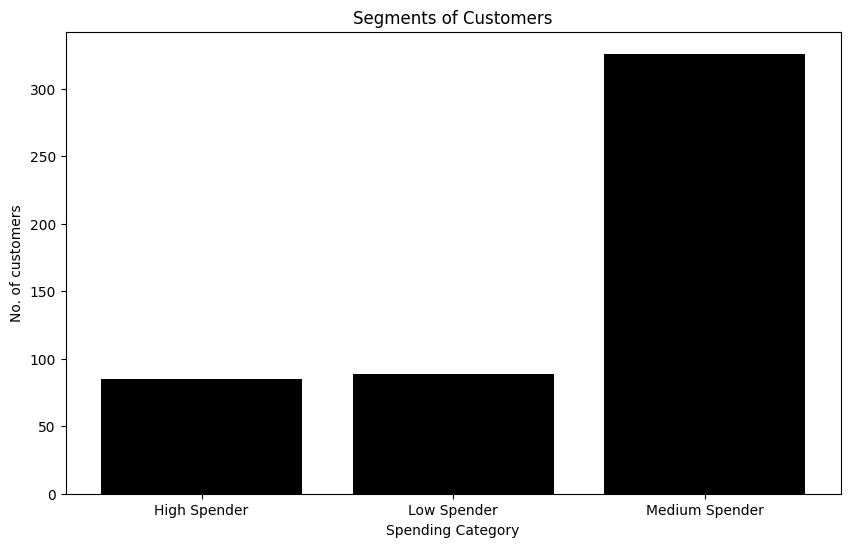

In [100]:
plt.figure(figsize=(10,6))
plt.bar(Customer_Segmentation.SpendingCategory,Customer_Segmentation.Customers,color = "Black")
plt.xlabel("Spending Category")
plt.ylabel("No. of customers")
plt.title("Segments of Customers")
plt.show()

In [101]:
# Analyze Characteristics and Purchasing Behavior of Each Segment

sqldf('''WITH CustomerSpending AS (
    SELECT
        CustomerID,
        SUM(Revenue) AS TotalSpending
    FROM dataSet
    GROUP BY CustomerID
),
CustomerSegments AS (
    SELECT
        CustomerID,
        TotalSpending,
        CASE
            WHEN TotalSpending >= 10000 THEN 'High Spender'
            WHEN TotalSpending >= 5000 AND TotalSpending < 10000 THEN 'Medium Spender'
            ELSE 'Low Spender'
        END AS SpendingCategory
    FROM CustomerSpending
),
SegmentCharacteristics AS (
    SELECT
        SpendingCategory,
        COUNT(CustomerID) AS CustomerCount,
        AVG(TotalSpending) AS AvgSpending,
        MIN(TotalSpending) AS MinSpending,
        MAX(TotalSpending) AS MaxSpending
    FROM CustomerSegments
    GROUP BY SpendingCategory
),
SegmentPurchasingBehavior AS (
    SELECT
        cs.SpendingCategory,
        COUNT(ds.OrderID) AS TotalOrders,
        SUM(ds.Quantity) AS TotalItemsPurchased,
        AVG(ds.Quantity) AS AvgItemsPerOrder,
        AVG(ds.Revenue) AS AvgOrderValue
    FROM CustomerSegments cs
    JOIN dataSet ds ON cs.CustomerID = ds.CustomerID
    GROUP BY cs.SpendingCategory
)
SELECT
    sc.SpendingCategory,
    sc.CustomerCount,
    sc.AvgSpending,
    sc.MinSpending,
    sc.MaxSpending,
    spb.TotalOrders,
    spb.TotalItemsPurchased,
    spb.AvgItemsPerOrder,
    spb.AvgOrderValue
FROM SegmentCharacteristics sc
JOIN SegmentPurchasingBehavior spb ON sc.SpendingCategory = spb.SpendingCategory;


''')

,SpendingCategory,CustomerCount,AvgSpending,MinSpending,MaxSpending,TotalOrders,TotalItemsPurchased,AvgItemsPerOrder,AvgOrderValue
0,High Spender,85,11729.694118,10040,15472,1427,16306,11.426769,698.685354
1,Low Spender,89,3979.235955,1584,4996,681,6020,8.839941,520.046990
2,Medium Spender,326,7421.349693,5004,9996,3891,40594,10.432794,621.783603


## Recommendations:

### High Spenders:
Exclusive Offers: Continue offering exclusive products or rewards to maintain engagement and encourage repeat purchases.

Personalization: Enhance personalized recommendations based on past high-value purchases to foster loyalty.

Premium Services: Introduce premium services such as VIP customer support or early access to new products to add more value.

### Low Spenders:
Discounts and Offers: Provide regular discounts, bundle offers, or loyalty rewards to incentivize larger purchases and increase order value.

Referral Programs: Implement referral incentives to attract new customers from this segment and expand their spending potential.

Engagement Campaigns: Launch frequent engagement campaigns via email or social media to keep the brand top-of-mind and encourage more frequent purchases.

### Medium Spenders:

Targeted Promotions: Offer targeted promotions based on their purchase history to encourage repeat purchases and increase average spending.

Enhanced Customer Experience: Improve user experience across platforms and streamline checkout processes to make shopping more convenient.

Cross-selling Opportunities: Implement strategies to upsell related products and increase average order value by suggesting complementary items.

By tailoring these strategies to each spending segment, the store can effectively increase engagement, satisfaction, and ultimately, sales from customers across different spending categories.

## 5. Cross-Selling Opportunities Identification:

## Steps to Identify Cross-Selling Opportunities:

### Data Preparation:
Ensure the dataset includes relevant columns such as OrderID, ProductID, and ProductName.

### Market Basket Analysis:
Perform SQL queries to count pairs of products purchased together frequently. 

This involves:Joining the dataset with itself on OrderID to find pairs of products bought in the same order.Counting the occurrences of each product pair.

Identify Frequently Purchased Pairs:Determine which pairs have the highest frequency of co-occurrence (i.e., products frequently bought together).

### Cross-Selling Strategy:

Once identified, suggest cross-selling opportunities based on frequent pairs. 

**For example:**

1. If Product A and Product B are frequently purchased together, consider bundling them at a discounted price.

2. Create product recommendations on the website suggesting "Frequently Bought Together" items during checkout.

3. Use email marketing to promote complementary products to customers who have purchased one item from a frequent pair.

In [102]:
sqldf('''WITH ProductPairs AS (
    SELECT
        p1.ProductID AS ProductID1,
        p2.ProductID AS ProductID2,
        COUNT(*) AS PairCount
    FROM dataSet p1
    JOIN dataSet p2 ON p1.OrderID = p2.OrderID
                  AND p1.ProductID < p2.ProductID
    GROUP BY ProductID1, ProductID2
    ORDER BY PairCount DESC
    LIMIT 10  -- Adjust this limit to see more pairs
)
SELECT * FROM ProductPairs;

''')

,ProductID1,ProductID2,PairCount


### Strategy for Implementation:

Implement Recommendations: Use the identified pairs to create product bundles or promotions.(NO product pair exist in our dataset)

Monitor Effectiveness: Track sales and conversion rates of these cross-selling strategies.

Feedback Loop: Use customer feedback and sales data to continuously refine and optimize cross-selling offers.

Segmentation: Tailor cross-selling offers based on customer segments (e.g., high spenders, medium spenders) identified earlier.

By leveraging market basket analysis and implementing targeted cross-selling strategies, the store can enhance customer satisfaction, increase average order value, and ultimately boost sales.